## Breast cancer classification

In [78]:
from sklearn                 import datasets
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble        import VotingClassifier, BaggingClassifier
from sklearn.ensemble        import AdaBoostClassifier, RandomForestClassifier

import os
import matplotlib.pyplot as plt
from pathlib import Path

### Load Data
Info can be shown via `dataset.keys()` and `dataset.DESCR`

In [3]:
dataset = datasets.load_breast_cancer()
X  = dataset.data  
y  = dataset.target

In [4]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

### Construct Ensemble method

In [16]:
# Instantiate Classifiers
lr  = LogisticRegression(random_state = 42, solver = 'newton-cg', max_iter = 1000, n_jobs = -1)
knn = KNeighborsClassifier(n_neighbors = 42)
dt  = DecisionTreeClassifier(min_samples_leaf = 0.13, random_state = 42)

In [19]:
# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

In [20]:
# fit classifiers singularly
for clf_name, clf in classifiers:     
    clf.fit(X_train, y_train)                           # Fit clf to the training set
    y_pred = clf.predict(X_test)                        # Predict y_pred
    accuracy = accuracy_score(y_pred, y_test)           # Calculate accuracy 
    print('{:s} : {:.3f} %'.format(clf_name, accuracy)) # Evaluate clf's accuracy on the test set

Logistic Regression : 0.965 %
K Nearest Neighbours : 0.930 %
Classification Tree : 0.921 %


In [21]:
# train ensemble model
vc = VotingClassifier(estimators = classifiers)     
# Fit vc to the training set
vc.fit(X_train, y_train)   
# Evaluate the test set predictions
y_pred = vc.predict(X_test)
# Calculate accuracy score
accuracy = accuracy_score(y_pred, y_test)
print('Voting Classifier: {:.3f} %'.format(accuracy))

Voting Classifier: 0.930 %


### Bootstrap aggregation (Bagging) with Out of Bag
- Bagging exploit one algorithm, $\neq$ subsets of the training set;
- **Random forest** is a specific case of Bagging
- Uses a technique known as the bootsrap.
- Reduces variance of individual models in the ensemble.
- On average, for each model within an ensemble construction, 63% of the training instances are sampled. The remaining 37% constitute the OOB instances.

In [22]:
# Instantiate dt
dt = DecisionTreeClassifier(random_state = 42)
# Instantiate bc
bc = BaggingClassifier(base_estimator = dt, n_estimators = 50, random_state = 42, oob_score=True)
# Fit bc to the training set
bc.fit(X_train, y_train)
# Predict test set labels
y_pred = bc.predict(X_test)

In [24]:
# Evaluate test set accuracy
acc_test = accuracy_score(y_pred, y_test)
# Evaluate OOB accuracy
acc_oob = bc.oob_score_
# Print acc_test and acc_oo
print('Test set accuracy: {:.3f} %, OOB accuracy: {:.3f} %'.format(acc_test, acc_oob))

Test set accuracy: 0.939 %, OOB accuracy: 0.952 %


### Adaptive Boosting (Adaboost)
- Boosting method: Ensemble method combined several weak learners to form a strong learner.
- Weak learner: Model doing slightly better than random guessing. Example of weak learner Decision stump , i.e., CART whose maximum depth is 1.
    Train an ensemble of predictors sequentially.
- Each predictor tries to correct its predecessor.
- Each predictor pays more attention to the instances wrongly predicted by its predecessor.
- Good prediction is achieved by changing the weights of training instances.
- Each predictor is assigned a coefficient $\alpha$ which depends on the predictor's training error.

In [26]:
# Instantiate dt
dt = DecisionTreeClassifier(max_depth = 2, random_state = 42)
# Instantiate ada
ada = AdaBoostClassifier(base_estimator = dt, n_estimators = 180, random_state = 42)
# Fit ada to the training set
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=180, random_state=42)

In [69]:
# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:,1]
# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)
# Print roc_auc_score
print('ROC AUC score: {:.2f} %'.format(ada_roc_auc * 100))

ROC AUC score: 99.01 %


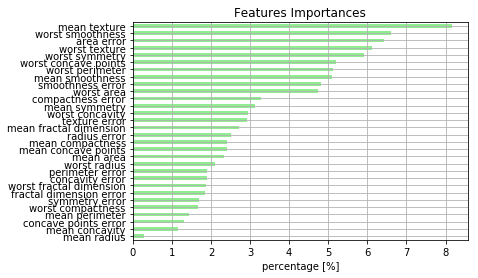

In [79]:
# Create a pd.Series of features importances
importances = pd.Series(data  = ada.feature_importances_,
                        index = dataset.feature_names)

# Sort importances
importances_sorted = importances.sort_values()
importances_sorted = importances_sorted.map(lambda x: round(x*100, 3)) 

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.xlabel('percentage [%]')
plt.grid()
plt.show()

### Tuning CART with GridSeachCV
Hyperparameter tuning via GridSearch Cross-Validation

In [50]:
rf = RandomForestClassifier(random_state = 42, oob_score = True)
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [68]:
# Define params_dt
params_rf = {'max_depth'        : [1, 2, 4, 6, 8], 
             'min_samples_leaf' : [0.05, 0.10, 0.12, 0.14],
             'n_estimators'     : [5, 10, 20, 40],
             'max_features'     : ['log2', 'auto', 'sqrt']}

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator  = rf,
                       param_grid = params_rf,
                       scoring    = 'roc_auc',
                       cv         = 5,
                       n_jobs     = -1)

In [64]:
# Fit 'grid_dt' to the training data
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [1, 2, 4, 6, 8], 'min_samples_leaf': [0.05, 0.1, 0.12, 0.14], 'n_estimators': [5, 10, 20, 40], 'max_features': ['log2', 'auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [67]:
# Extract the best estimator
best_model = grid_dt.best_estimator_
print(best_model)
# Predict the test set probabilities of the positive class
y_pred_proba = best_model.predict_proba(X_test)[:,1]
# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
# Print test_roc_auc
print('o Test set ROC AUC score: {:.3f}'.format(test_roc_auc))
# Evaluate test set accuracy
test_acc = best_model.score(X_test, y_test)
# Print test set accuracy
print("o Test set accuracy of best model: {:.3f}".format(test_acc))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.05, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)
o Test set ROC AUC score: 0.991
o Test set accuracy of best model: 0.956
